In [1]:
import os
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
csv_path = os.path.join('town_data.csv')
town_data = pd.read_csv(csv_path)

In [3]:
town_data.head()

,town,accountants_per_10000_residents_2013,apartments_condos_multis_per_residential_parcels_2011,architects_per_10000_2013,assessed_home_value_changes_2009-2013,barbers_per_10000_residents_2013,births_per_1000_residents_2010,boaters_per_10000_residents_2012,burglaries_per_10000_residents_2011,cars_motorcycles_&_trucks_average_age_2012,...,tax_bills_for_single-family_homes_2013,taxable_property_by_percent_2012,teacher_salaries_by_average_2011,teachers_percent_under_40_years_old_2011-2012,trucks_per_1000_residents_2012,veterinarians_per_10000_2013,violent_crimes_per_10000_residents_2012,voters_as_a_percent_of_population_2012,voters_change_in_registrations_between_1982-2012,2020_label
0,Abington,29.4,0.219,3.8,-0.149,8.1,12.1,137.6,63.5,9.9,...,4756.0,92.9,73887.0,0.32,354,1.3,25.3,10902,0.51,light blue
1,Acton,36.0,0.329,10.5,-0.004,1.8,8.2,69.8,10.4,8.5,...,9650.0,93.7,75741.0,0.31,280,6.4,10.3,14398,0.34,wicked blue
2,Acushnet,7.8,0.050,0.0,-0.188,7.8,8.0,287.3,41.7,10.9,...,3380.0,95.1,57227.0,0.43,379,1.9,12.5,7478,0.44,red
3,Adams,5.9,0.209,1.2,-0.051,11.8,10.3,212.1,77.1,10.0,...,2453.0,88.0,NaN,NaN,366,0.0,48.2,5980,-0.03,medium blue
4,Agawam,15.1,0.214,1.4,-0.107,8.1,9.6,246.1,19.3,9.7,...,3245.0,88.1,60647.0,0.36,328,2.1,11.8,21365,0.63,red


In [4]:
town_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 75 columns):
 #   Column                                                            Non-Null Count  Dtype  
---  ------                                                            --------------  -----  
 0   town                                                              350 non-null    object 
 1   accountants_per_10000_residents_2013                              350 non-null    float64
 2   apartments_condos_multis_per_residential_parcels_2011             349 non-null    float64
 3   architects_per_10000_2013                                         350 non-null    float64
 4   assessed_home_value_changes_2009-2013                             335 non-null    float64
 5   barbers_per_10000_residents_2013                                  350 non-null    float64
 6   births_per_1000_residents_2010                                    350 non-null    float64
 7   boaters_per_10000_residents_2012   

In [5]:
na_town_feature_series = town_data.isna().sum().sort_values(ascending=False)
display(na_town_feature_series)


teacher_salaries_by_average_2011                 119
pupils_per_cost_average_by_district_2011-2012    114
minority_students_per_district_2012-2013         113
school_district_growth_09-13                     113
class_size_in_school_district_2011-2012          113
                                                ... 
inmates_in_state_prison_per_1000_residents         0
median_age_2011                                    0
miles_driven_daily_per_household_05-07             0
motorcycles_change_in_ownership_2000-2012          0
2020_label                                         0
Length: 75, dtype: int64

There appears to be a few columns with a lot of missing data. Lets investigate further

In [6]:
na_town_feature_series[na_town_feature_series > .25*len(town_data)]


teacher_salaries_by_average_2011                 119
pupils_per_cost_average_by_district_2011-2012    114
minority_students_per_district_2012-2013         113
school_district_growth_09-13                     113
class_size_in_school_district_2011-2012          113
teachers_percent_under_40_years_old_2011-2012    110
dtype: int64

Here we can see these categories are missing for more than 25% of the data. Its worth noting that none of these features are missing for more than 50% of the data so they will not be dropped. 

Lets see how we should handle these missing values by taking a look at their distributions and statistics

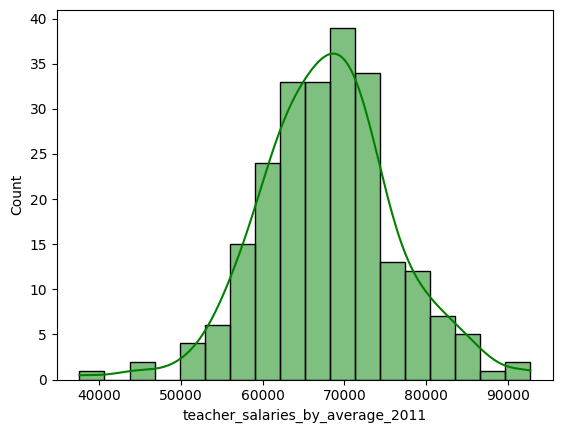

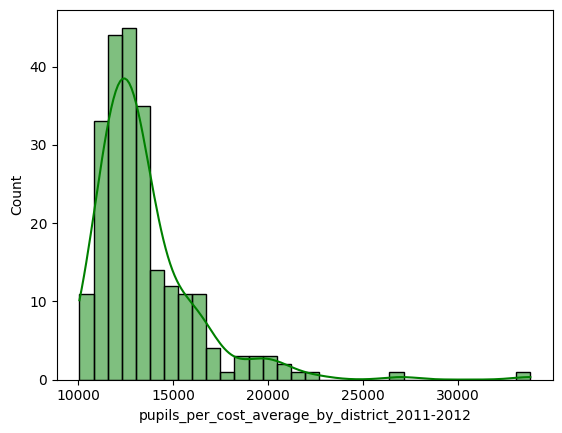

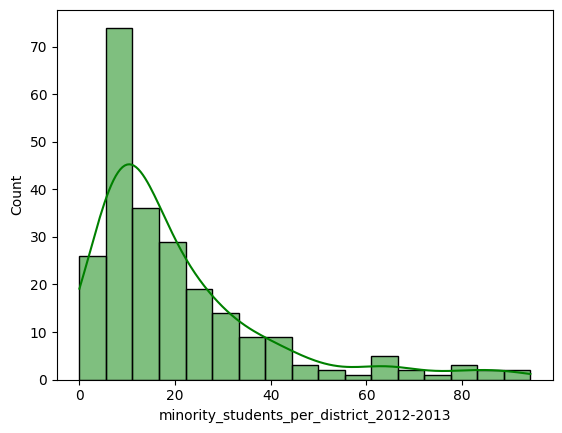

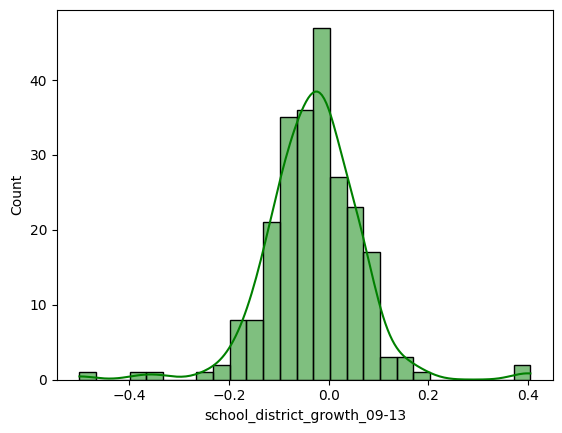

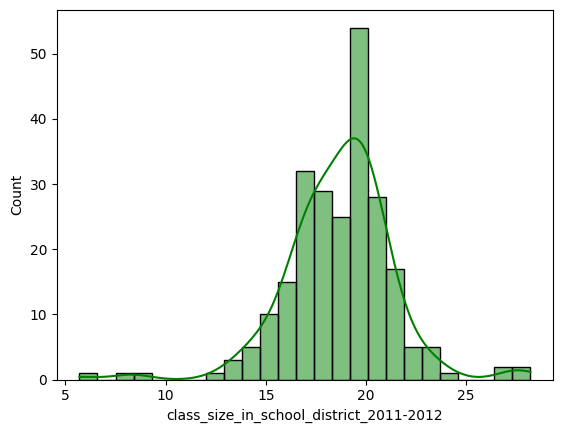

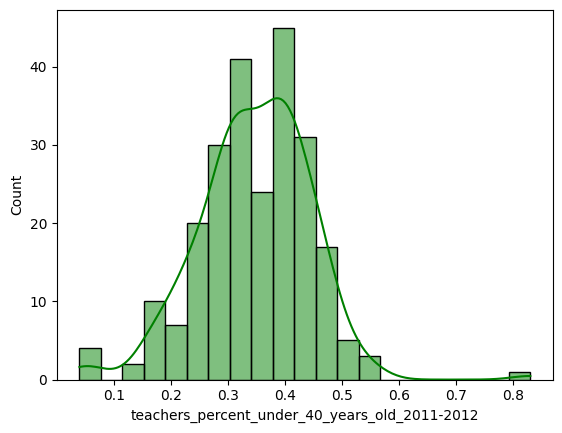

,teacher_salaries_by_average_2011,pupils_per_cost_average_by_district_2011-2012,minority_students_per_district_2012-2013,school_district_growth_09-13,class_size_in_school_district_2011-2012,teachers_percent_under_40_years_old_2011-2012
count,231.000000,236.000000,237.000000,237.000000,237.000000,240.000000
mean,67912.952381,13502.961864,20.400422,-0.029987,18.678059,0.346958
std,8163.202881,2783.891986,18.493241,0.094813,2.697838,0.097998
min,37580.000000,10064.000000,0.000000,-0.500000,5.700000,0.040000
25%,62619.500000,11904.000000,8.700000,-0.083000,17.200000,0.290000
50%,68077.000000,12784.500000,14.000000,-0.028000,18.900000,0.350000
75%,72534.000000,14197.250000,26.300000,0.023000,20.100000,0.410000
max,92765.000000,33811.000000,94.300000,0.405000,28.200000,0.830000


In [7]:
na_label_list = na_town_feature_series[na_town_feature_series > .25*len(town_data)].index.tolist()

plot = plt.plot(figsize=(15, 15))
for label in na_label_list:
   
    sns.histplot(data=town_data,x=label,kde=True,color='g')

    plt.show()

town_data[na_label_list].describe()


From the table and plots above, we can see that "pupils_per_cost_average_by_district_2011-2012" and	"minority_students_per_district_2012-2013" are heavily skewed. So for these features, we will impute the median values. The remaining columns can be imputed using the mean

In [8]:
town_labels = town_data["2020_label"]
town_features = town_data.drop("2020_label", axis=1)

##### Data Preparation and Cleaning

In [9]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(town_features, town_labels, test_size=0.2, random_state=42)



# Town names are not useful for training, but will be needed later
X_train_towns = X_train["town"]
X_train = X_train.drop("town", axis=1)

X_test_towns = X_test["town"]
X_test = X_test.drop("town", axis=1)
features = list(X_train.columns)


# Separate median and mean features
median_features = ["pupils_per_cost_average_by_district_2011-2012", "minority_students_per_district_2012-2013"]
mean_features = list(set(features) - set(median_features))


# Create median and mean pipelines with imputer and scaler
median_pipeline = Pipeline([
    ('median_imputer', SimpleImputer(strategy="median")),
    ("std_scale", StandardScaler())
])
mean_pipeline = Pipeline([
     ('mean_imputer', SimpleImputer(strategy="mean")),
    ("std_scale", StandardScaler())

])

# Apply pipelines to specified columns
column_transform = ColumnTransformer([
    ("median_pipeline", median_pipeline, median_features),
    ('mean_pipeline', mean_pipeline, mean_features)
])

cat_pipeline = Pipeline([
    ('cat', OrdinalEncoder())
])

y_train = y_train.values.reshape(-1,1) # Reformat y for pipeline
y_test = y_test.values.reshape(-1,1)
y_train_tr = cat_pipeline.fit_transform(y_train)
y_test_tr = cat_pipeline.transform(y_test)

X_train_tr = column_transform.fit_transform(X_train) # transformed town data
X_test_tr = column_transform.transform(X_test)

X_train_DF = pd.DataFrame(data=X_train_tr, index=[X_train_towns], columns=[X_train.columns])
X_train_tr = X_train_DF
display(X_train_tr)


,accountants_per_10000_residents_2013,apartments_condos_multis_per_residential_parcels_2011,architects_per_10000_2013,assessed_home_value_changes_2009-2013,barbers_per_10000_residents_2013,births_per_1000_residents_2010,boaters_per_10000_residents_2012,burglaries_per_10000_residents_2011,cars_motorcycles_&_trucks_average_age_2012,cars_per_1000_residents_2012,...,tax_bills_for_single-family_homes_2012,tax_bills_for_single-family_homes_2013,taxable_property_by_percent_2012,teacher_salaries_by_average_2011,teachers_percent_under_40_years_old_2011-2012,trucks_per_1000_residents_2012,veterinarians_per_10000_2013,violent_crimes_per_10000_residents_2012,voters_as_a_percent_of_population_2012,voters_change_in_registrations_between_1982-2012
town,,,,,,,,,,,,,,,,,,,,,
Pelham,0.646411,0.445405,-0.787560,0.268148,0.881795,-0.192301,-0.614115,-0.877494,-0.443001,-1.263589,...,-1.318476,0.155124,-1.042938,-0.477648,-0.657272,-0.954686,0.608806,-1.858593e+00,-0.276780,0.581309
Dover,2.419538,-0.040037,-0.787560,-0.660422,3.396019,-0.128880,-1.950147,-1.287470,-0.323103,-1.048538,...,-0.998759,-0.448353,2.239891,2.062302,-0.303952,0.156181,3.580456,1.120394e+00,-0.583804,3.537818
Egremont,-0.207497,-0.285995,-0.787560,-1.622155,-0.714191,-0.615107,0.853870,-1.164477,-0.444749,-0.442484,...,-0.174875,-1.117267,0.449257,-1.572455,-0.347216,1.224322,-0.741356,4.611188e+00,-0.424404,-0.767382
Attleboro,-0.862562,0.529548,-0.438211,0.997739,-0.639857,0.589889,0.227090,-0.139538,0.554327,0.349295,...,0.000000,-0.855518,-0.595279,0.135443,0.164736,0.327083,-0.595081,-2.706748e-01,-0.578757,-0.554730
Colrain,-0.207497,-0.285995,-0.787560,0.997739,-0.821319,0.272785,0.243584,1.131386,-0.437037,0.000000,...,0.000000,1.791055,-1.192157,-0.302479,0.921849,-1.467394,-0.804112,4.662328e-16,-0.197921,-0.794127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Danvers,-0.188145,-0.428391,0.959185,-0.196137,-0.397180,-0.636247,0.688928,-0.016545,0.238360,-0.435968,...,1.472894,-0.690107,0.150818,-0.433856,-0.058792,0.540711,0.116454,1.803754e-02,-0.122637,0.159514
Gloucester,0.303880,-0.493117,0.571019,0.102332,-0.919701,-0.340283,1.282720,0.065450,0.312327,-0.589110,...,-0.224062,-0.455624,0.150818,-1.090740,1.938543,0.070729,0.406697,-3.445561e-02,1.236680,0.427411
Shutesbury,1.027645,0.199447,-0.787560,-0.361953,0.726569,1.625763,-0.267736,-1.123479,-0.425943,0.000000,...,0.000000,0.013343,-1.490596,-0.171103,-0.931274,-1.082863,0.093382,4.662328e-16,0.325912,0.128823


town_data[na_label_list].var()

## Model Exploration: Decision Tree, Random Forest, KNN

In [10]:
# Decision Tree Classifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import randint

basic_tree = DecisionTreeClassifier(random_state=42)

param_dist_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_leaf': [3, 5, 10, 15, 20, 50],
    'max_features': [3, 5, 10, 15, 20, 70]
}

basic_tree_clf = GridSearchCV(basic_tree, param_dist_tree, cv=5)


In [11]:
basic_tree_clf.fit(X_train_tr, y_train_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15],
                         'max_features': [3, 5, 10, 15, 20, 70],
                         'min_samples_leaf': [3, 5, 10, 15, 20, 50]})

In [12]:
print(basic_tree_clf.best_estimator_)
print(basic_tree_clf.best_params_)
print(basic_tree_clf.best_score_)

DecisionTreeClassifier(max_features=70, min_samples_leaf=15, random_state=42)
{'criterion': 'gini', 'max_depth': None, 'max_features': 70, 'min_samples_leaf': 15}
0.5607142857142857


In [13]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state=42)

param_grid_forest = {
    'n_estimators': [50, 75, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 25],
    'bootstrap': [True, False]
    
}

forest_clf = GridSearchCV(forest, param_grid_forest, cv=5, n_jobs=-1)

In [14]:
forest_clf.fit(X_train_tr, y_train_tr.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 25],
                         'n_estimators': [50, 75, 100, 150, 200, 250]})

In [15]:

print(forest_clf.best_estimator_)
print(forest_clf.best_params_)
print(forest_clf.best_score_)

RandomForestClassifier(bootstrap=False, max_depth=5, n_estimators=50,
                       random_state=42)
{'bootstrap': False, 'max_depth': 5, 'n_estimators': 50}
0.65


In [16]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

KNN = KNeighborsClassifier()

param_grid_KNN = {
    'n_neighbors':[2, 3, 4, 5, 10]
}

KNN_clf = GridSearchCV(KNN, param_grid_KNN, cv=5) 


In [17]:
KNN_clf.fit(X_train_tr, y_train_tr.ravel())


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 10]})

In [18]:
print(KNN_clf.best_estimator_)
print(KNN_clf.best_params_)
print(KNN_clf.best_score_)

KNeighborsClassifier()
{'n_neighbors': 5}
0.5357142857142858


In [19]:
# XGBoost
cat_pipeline = Pipeline([
    ('cat', OrdinalEncoder())
])

xgb_clf = XGBClassifier()

xgb_clf.fit(X_train_tr, y_train_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

##### Evaluation on Test Set

In [20]:
# Tree test set evaluation
y_test_tree = basic_tree_clf.predict(X_test_tr)

tree_acc =  accuracy_score(y_test_tr, y_test_tree)
tree_f1 = f1_score(y_test_tr, y_test_tree, average='macro')

print("Tree final performance")
print(f"Accuracy: {tree_acc}")
print(f"F1 Score: {tree_f1}")

Tree final performance
Accuracy: 0.6142857142857143
F1 Score: 0.6167387132236486


In [21]:
# Forest test set evaluation
y_test_forest = forest_clf.predict(X_test_tr)

forest_acc =  accuracy_score(y_test_tr, y_test_forest)
forest_f1 = f1_score(y_test_tr, y_test_forest, average='weighted')

print("Forest final performance")
print(f"Accuracy: {forest_acc}")
print(f"F1 Score: {forest_f1}")

Forest final performance
Accuracy: 0.7571428571428571
F1 Score: 0.7539230135138512


In [22]:
# KNN test set evaluation
y_test_KNN = KNN_clf.predict(X_test_tr)

KNN_acc =  accuracy_score(y_test_tr, y_test_KNN)
KNN_f1 = f1_score(y_test_tr, y_test_KNN, average='weighted')

print("K Nearest Neighbors final performance")
print(f"Accuracy: {KNN_acc}")
print(f"F1 Score: {KNN_f1}")


K Nearest Neighbors final performance
Accuracy: 0.6285714285714286
F1 Score: 0.6320761752016669


In [23]:
# XGBoost test set evaluation
y_test_xgb = xgb_clf.predict(X_test_tr)

xgb_acc =  accuracy_score(y_test_tr, y_test_xgb)
xgb_f1 = f1_score(y_test_tr, y_test_xgb, average='weighted')

print("XGBoost final performance")
print(f"Accuracy: {xgb_acc}")
print(f"F1 Score: {xgb_f1}")

XGBoost final performance
Accuracy: 0.6571428571428571
F1 Score: 0.6546725680384217


# Results

Most important Features:


,Feature,Importance Score
57,school_district_growth_09-13,0.051998
27,historic_places_per_10000_2013,0.042449
37,inmates_in_state_prison_per_1000_residents,0.039957
58,single-person_households_percent_65_and_older,0.037824
66,teacher_salaries_by_average_2011,0.032352
53,pupils_per_cost_average_by_district_2011-2012,0.032138
12,construction_supervisors_per_10000_2013,0.031593
7,burglaries_per_10000_residents_2011,0.030207
45,multi-generation_households_2010,0.028910
33,hybrid_cars_per_1000_vehicles_2013,0.028100


Least important Features:


,Feature,Importance Score
34,in_home_since_1969_or_earlier,0.002283
49,population_change_1950-2010,0.002791
10,class_size_in_school_district_2011-2012,0.003028
20,expenditures_per_resident_2012,0.003253
43,motorcycles_change_in_ownership_2000-2012,0.003272
62,tax-exempt_property_2012,0.004420
23,firefighter_costs_per_resident_2012,0.004456
69,veterinarians_per_10000_2013,0.004578
42,minority_students_per_district_2012-2013,0.004877
5,births_per_1000_residents_2010,0.004893


<Axes: title={'center': 'Feature Importance by Gain'}, xlabel='F score', ylabel='Features'>

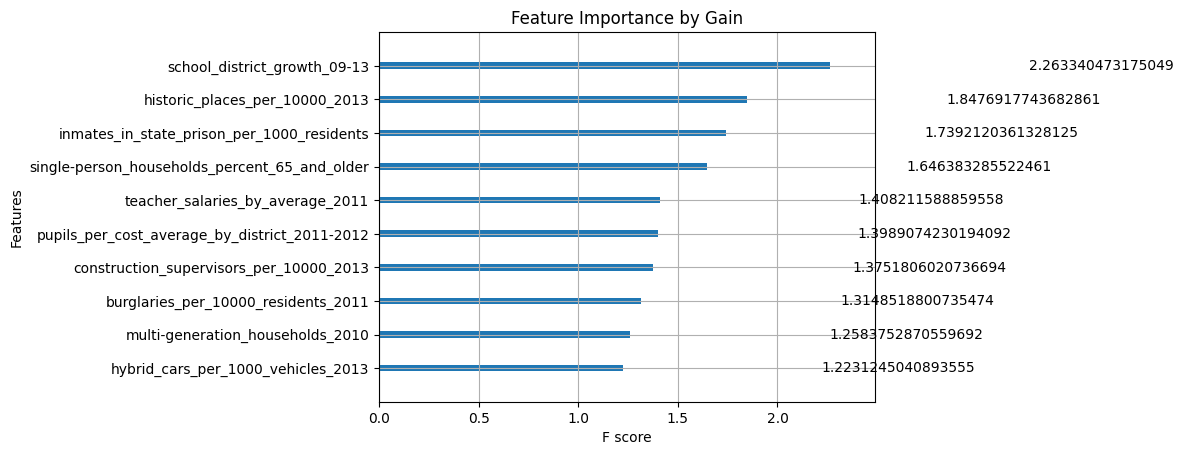

In [24]:
xgb_clf.feature_importances_
importance_data = {'Feature': X_train.columns,'Importance Score':xgb_clf.feature_importances_}
features_importances = pd.DataFrame(data= importance_data)
print("Most important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = False)[:10])
print("Least important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = True)[:10])
# Using Gain to measure feature importance. Gain being a measure in the imporvement of accuracy as a result of branching
xgb.plot_importance(xgb_clf, max_num_features=10, importance_type='gain', title='Feature Importance by Gain') 

# Generalization to Democratic vs Republican Binary


In [25]:
import numpy as np
labels_inverse = cat_pipeline.inverse_transform(y_train_tr) # FIX THIS 

# Here we find that red == 2
# Create new labels where red = 0 and blue variants are all 1
y_train_binary = np.where(y_train_tr == 2, 0., 1.)
y_test_binary = np.where(y_test_tr == 2, 0., 1.) 

NotFittedError: This OrdinalEncoder instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

##### Binary Classification Training 

In [23]:
# Random Forest Binary Classification

forest_binary = RandomForestClassifier(random_state=42)

param_grid_forest = {
    'n_estimators': [50, 75, 100, 150, 200, 250],
    'max_depth': [None, 5, 10, 25],
    'bootstrap': [True, False]
    
}

forest_binary_clf = GridSearchCV(forest_binary, param_grid_forest, cv=5, n_jobs=-1)
forest_binary_clf.fit(X_train_tr, y_train_binary.ravel())

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 5, 10, 25],
                         'n_estimators': [50, 75, 100, 150, 200, 250]})

In [24]:
# XGBoost Binary Classification
xgb_binary_clf = XGBClassifier()

xgb_binary_clf.fit(X_train_tr, y_train_binary.ravel())

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

##### Binary Classification Model Evaluation

In [25]:
# Forest Binary test set evaluation
y_test_forest_binary = forest_binary_clf.predict(X_test_tr)

forest_acc =  accuracy_score(y_test_binary, y_test_forest_binary)
forest_f1 = f1_score(y_test_binary, y_test_forest_binary, average ='binary')

print("Forest Binary final performance")
print(f"Accuracy: {forest_acc}")
print(f"F1 Score: {forest_f1}")

Forest Binary final performance
Accuracy: 0.9
F1 Score: 0.9345794392523364


In [26]:
# XGBoost test set evaluation
y_test_xgb_binary = xgb_binary_clf.predict(X_test_tr)

xgb_acc =  accuracy_score(y_test_binary, y_test_xgb_binary)
xgb_f1 = f1_score(y_test_binary, y_test_xgb_binary, average='binary')

print("XGBoost Binary final performance")
print(f"Accuracy: {xgb_acc}")
print(f"F1 Score: {xgb_f1}")

XGBoost Binary final performance
Accuracy: 0.9142857142857143
F1 Score: 0.9433962264150944


##### Feature Examination for Binary Classification

In [27]:


xgb_clf.feature_importances_
importance_data = {'Feature': X_train.columns,'Importance Score':xgb_binary_clf.feature_importances_}
features_importances = pd.DataFrame(data= importance_data)
print("Most important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = False)[:10])
print("Least important Features:")
display(features_importances.sort_values(by='Importance Score', ascending = True)[:10])


Most important Features:


,Feature,Importance Score
42,minority_students_per_district_2012-2013,0.124944
35,income_average_per_resident_2010,0.073176
44,motorcycles_per_1000_2012,0.062733
31,households_average_size_2010,0.045938
3,assessed_home_value_changes_2009-2013,0.044266
12,construction_supervisors_per_10000_2013,0.041461
1,apartments_condos_multis_per_residential_parce...,0.041347
50,population_change_2010-2011,0.034271
33,hybrid_cars_per_1000_vehicles_2013,0.032727
45,multi-generation_households_2010,0.031246


Least important Features:


,Feature,Importance Score
36,income_change_per_resident_2007-2010,0.000000
66,teacher_salaries_by_average_2011,0.000000
57,school_district_growth_09-13,0.000000
46,police_costs_per_resident_2013,0.000000
37,inmates_in_state_prison_per_1000_residents,0.000000
28,home_schooled_per_1000_students_2011-2012,0.000000
11,condos_as_perc_of_parcels_2012,0.000000
72,voters_change_in_registrations_between_1982-2012,0.000000
23,firefighter_costs_per_resident_2012,0.001181
14,culture_and_rec_spending_per_person_2012,0.001398


<AxesSubplot:title={'center':'Feature Importance by Gain'}, xlabel='F score', ylabel='Features'>

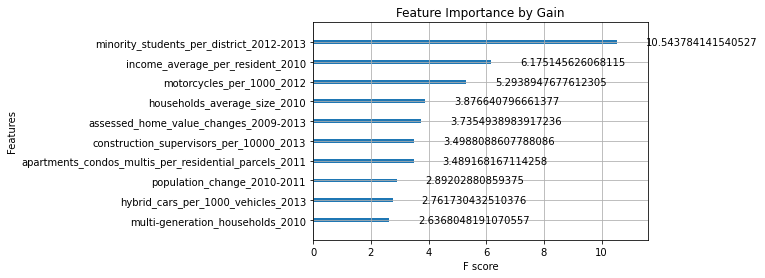

In [28]:
xgb.plot_importance(xgb_binary_clf, max_num_features=10, importance_type='gain', title='Feature Importance by Gain') 